This notebook was used to visualize the five latent variables 
in latitude-longitude plots together with sub-grid-scale and large-scale varaibles from the test data set

In [1]:
## import some packages 

import xarray as xr
import numpy as np
import math
import scipy as sc
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import matplotlib.image as imag


import pickle

In [2]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as mp

from tensorflow.keras.layers import Lambda, Input, Dense
from cbrain.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler,Callback


import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


import tensorflow as tf
from cbrain.imports import *

from cbrain.utils import *
import pandas as ps

# reparameterization trick of VAE 
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    based on VAE presented on keras webpage for keras version 1 /
    recent keras VAE version can be seen on
    https://keras.io/examples/generative/vae/
    """

    z_mean, z_log_var = args
    batch= K.shape(z_mean)[0]
    dim=K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon=K.random_normal(shape=(batch,dim)) # epsilion= random_normal distributed tensor
    sample_prob=z_mean+K.exp(0.5*z_log_var)*epsilon #exp= elementwise exponential
    return sample_prob

# kl annealing to improve reproduction skills of VAE 
klstart = 2
# number of epochs over which KL scaling is increased from 0 to 1
kl_annealtime = 5

class AnnealingCallback(Callback):
    def __init__(self, weight):
        self.weight = weight
    def on_epoch_end (self, epoch, logs={}):
        if epoch > klstart :
            new_weight = min(K.get_value(self.weight) + (1./kl_annealtime), 1.)
            K.set_value(self.weight, new_weight)
        print ("Current KL Weight is " + str(K.get_value(self.weight)))


# the starting value of weight is 0
# define it as a keras backend variable
weight = K.variable(0.)

    
original_dim_input=64  # input node size (CAM variables)

original_dim_output=int(65+64) # output node size (SP + CAM variables)


# network parameters
input_shape = (original_dim_input,)
out_shape=(original_dim_output,)
intermediate_dim = 463 # nodes in first hidden layers of encoder and last hidden layers of decoder 
batch_size = 714
latent_dim = 5 # latent space dimensions
epochs = 40    
    
## Encoder 
inputs =Input(shape=input_shape, name='encoder_input')
x_0 =Dense(intermediate_dim, activation='relu')(inputs)
x_1 =Dense(intermediate_dim, activation='relu')(x_0)
x_2 =Dense(int(np.round(intermediate_dim/2)), activation='relu')(x_1)
x_3 =Dense(int(np.round(intermediate_dim/4)), activation='relu')(x_2)
x_4 =Dense(int(np.round(intermediate_dim/8)), activation='relu')(x_3)
x_5 =Dense(int(np.round(intermediate_dim/16)), activation='relu')(x_4)



z_mean = Dense(latent_dim, name='z_mean')(x_5)
z_log_var = Dense(latent_dim, name='z_log_var')(x_5)



# reparametrization trick
z = Lambda(sampling, output_shape=(latent_dim), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()


## Decoder
decoder_inputs =Input(shape=(latent_dim,), name='decoder_input')
x_1 =Dense(int(np.round(intermediate_dim/16)), activation='relu')(decoder_inputs)
x_2 =Dense(int(np.round(intermediate_dim/8)), activation='relu')(x_1)
x_3 =Dense(int(np.round(intermediate_dim/4)), activation='relu')(x_2)
x_4 =Dense(int(np.round(intermediate_dim/2)), activation='relu')(x_3)
x_5 =Dense(intermediate_dim, activation='relu')(x_4)
x_6 =Dense(intermediate_dim, activation='relu')(x_5)

outputs = Dense(original_dim_output, activation='elu')(x_6)

decoder = Model(decoder_inputs, outputs, name='decoder')
decoder.summary()

emul_outputs=decoder(encoder(inputs)[2])

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
VAE_loss = K.mean(kl_loss*weight)


VAE_clim_clim_conv=Model(inputs,emul_outputs)
VAE_clim_clim_conv.add_loss(VAE_loss)
VAE_clim_clim_conv.add_metric(kl_loss, name='kl_loss', aggregation='mean')


#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)

scale_array=ps.read_csv('nn_config/scale_dicts/Scaling_cond_VAE.csv')


PHQ_std_surf=scale_array.PHQ_std.values[-1]

TPHYSTND_std_23=scale_array.TPHYSTND_std.values[-1]# for dT/dt we are using the std on level 23 ~ 845 hPa

PRECT_std=scale_array.PRECT_std.values
FSNS_std=scale_array.FSNS_std.values
FSNT_std=scale_array.FSNT_std.values
FLNS_std=scale_array.FLNS_std.values
FLNT_std=scale_array.FLNT_std.values

# and the CAM variables 
scale_array_2D=ps.read_csv('nn_config/scale_dicts/Scaling_enc_II_range_profiles.csv')
scale_array_1D=ps.read_csv('nn_config/scale_dicts/Scaling_enc_II_range.csv')

TBP_std_surf=scale_array_2D.TBP_std.values[-1]

QBP_std_surf=scale_array_2D.QBP_std.values[-1]

Q_lat_std_surf=scale_array_1D.Q_lat_std.values

Q_sens_std_surf=scale_array_1D.Q_sens_std.values


Q_solar_std_surf=scale_array_1D.Q_sol_std.values

PS_std_surf=scale_array_1D.PS_std.values


# defining the scaling dict for the VAE training 

scale_dict_II = {
    'PHQ': 1/PHQ_std_surf, 
    'QBP':1/QBP_std_surf,
    'TPHYSTND': 1/TPHYSTND_std_23, 
    'TBP':1/TBP_std_surf,
    'FSNT': 1/FSNT_std, 
    'FSNS': 1/FSNS_std, 
    'FLNT': 1/FLNT_std, 
    'FLNS': 1/FLNS_std, 
    'PRECT': 1/PRECT_std, 
    'LHFLX': 1/Q_lat_std_surf, 
    'SHFLX': 1/Q_sens_std_surf, 
    'SOLIN': 1/Q_solar_std_surf,
    'PS':1/PS_std_surf
}

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT','QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']

## CAM variables
#QBP = specific humidity
#TBP = temperature 
#PS = surface pressure 
#SOLIN = solar insolation
#SHFLX = surface sensible heat flux 
#LHFLX = surface latent heat flux

##  SP variables=
#PHQ = specific humidity tendency 
#TPHYSTND = temperature tendency 
#FSNT = shortwave heat flux model top
#FSNS = shortwave heat flux model surface 
#FLNT = longwave heat flux model top (OLR)
#FLNS = longwave heat flux model surface 
#PRECT = precipitation rate 

# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1];


Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 463)          30095       encoder_input[0][0]              
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 463)          214832      dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 232)          107648      dense_1[0][0]                    
____________________________________________________________________________________________

In [3]:
VAE_clim_clim_conv.load_weights('./saved_models/VAE_clim_clim_conv/VAE_clim_clim_conv_BN5_40_opt_anneal.h5')


In [5]:
## setting a few formatting options for the plots 

fz = 24 # default fontsize
lw = 4 # default linewidth
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw



In [6]:
#loading the output normalization scalars for SP variables ( stds over 3 months of SP simulation)
import pandas as ps
from cbrain.imports import *

from cbrain.utils import *
scale_array=ps.read_csv('nn_config/scale_dicts/Scaling_cond_VAE.csv')


PHQ_std_surf=scale_array.PHQ_std.values[-1]

TPHYSTND_std_23=scale_array.TPHYSTND_std.values[-1]# for dT/dt we are using the std on level 23 ~ 845 hPa

PRECT_std=scale_array.PRECT_std.values
FSNS_std=scale_array.FSNS_std.values
FSNT_std=scale_array.FSNT_std.values
FLNS_std=scale_array.FLNS_std.values
FLNT_std=scale_array.FLNT_std.values

# and the CAM variables 
scale_array_2D=ps.read_csv('nn_config/scale_dicts/Scaling_enc_II_range_profiles.csv')
scale_array_1D=ps.read_csv('nn_config/scale_dicts/Scaling_enc_II_range.csv')

TBP_std_surf=scale_array_2D.TBP_std.values[-1]

QBP_std_surf=scale_array_2D.QBP_std.values[-1]

Q_lat_std_surf=scale_array_1D.Q_lat_std.values

Q_sens_std_surf=scale_array_1D.Q_sens_std.values


Q_solar_std_surf=scale_array_1D.Q_sol_std.values

PS_std_surf=scale_array_1D.PS_std.values


# defining the scaling dict for the VAE training 

scale_dict_II = {
    'PHQ': 1/PHQ_std_surf, 
    'QBP':1/QBP_std_surf,
    'TPHYSTND': 1/TPHYSTND_std_23, 
    'TBP':1/TBP_std_surf,
    'FSNT': 1/FSNT_std, 
    'FSNS': 1/FSNS_std, 
    'FLNT': 1/FLNT_std, 
    'FLNS': 1/FLNS_std, 
    'PRECT': 1/PRECT_std, 
    'LHFLX': 1/Q_lat_std_surf, 
    'SHFLX': 1/Q_sens_std_surf, 
    'SOLIN': 1/Q_solar_std_surf,
    'PS':1/PS_std_surf
}

in_vars = ['QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT','QBP', 'TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']

In [7]:
from cbrain.data_generator import DataGenerator
# use of the test data set again
val_gen_II = DataGenerator(
    data_fn = '../preprocessed_data/1918_train_3_month_OND.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '../preprocessed_data/000_norm_1_month.nc',
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_II,
    batch_size=8192,
    shuffle=True
)


# time steps of test data set 
time=4415




In [8]:
lon=np.arange(-180, 180, 360/128)
lat=np.arange(-90, 90, 180/64)

In [9]:
encoder_resp_=np.load('VAE_clim_clim_conv_encoder_pred_3_month_global.npy')

In [13]:
encoder_resp_pca=PCA(n_components=2).fit_transform(encoder_resp_)


In [14]:
# Based on https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights,glob_mean):
    """
    author: Gunnar Behrens 
    Return the weighted average, standard deviation, and 
    anomaly to noise ratio (cond_average - global_mean)/cond_std.
    values, weights -- np ndarrays with the same shape.
    
    set np.nan flags for single-values or constant values in grid cells (variance==0)
    """
    
#    print(weights.sum())
    if weights.sum()>0:
        average = np.average(values, weights=weights) # compute grid-cell average
        variance = np.average((values-average)**2, weights=weights)# and variance

        if variance>0:
            anomal_std_ratio=(average-glob_mean)/np.sqrt(variance)
            
        if variance==0:
            
            anomal_std_ratio=np.nan
            
        
        return (average, np.sqrt(variance),anomal_std_ratio)
    if  weights.sum()==0:
        
        average = np.nan
        variance =np.nan
        anomal_std_ratio=np.nan
        
        return (average, np.sqrt(variance),anomal_std_ratio)
        
        

# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(y_bin_edges,x_bin_edges,field_x,field_y,global_mean_y):
    """
    produce conditional average and std fields for 2D PCA compressed latent space
    """
    # Initialization
    Nbin = np.size(x_bin_edges)
    Ym = np.zeros((Nbin-1,Nbin-1))
    Ystd = np.copy(Ym)
    Yanomaly_std_ratio=np.copy(Ym)
    edge_left=x_bin_edges[0]
    y_edge_bottom=y_bin_edges[0]
    for jbin,y_edge in enumerate(y_bin_edges):
        print('jbin=',jbin,'/',Nbin-1,' & edge=',y_edge,end="\r")

        for ibin,edge in enumerate(x_bin_edges):
#            print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
            if jbin>0:
                if ibin>0:
                    w = ((field_x[:,0]>=edge_left)&(field_x[:,0]<edge))&((field_x[:,1]>=y_edge_bottom)&(field_x[:,1]<y_edge))
                    #print(w.shape)
                    Ym[jbin-1,ibin-1],Ystd[jbin-1,ibin-1],Yanomaly_std_ratio[jbin-1,ibin-1] = weighted_avg_and_std(field_y,w,global_mean_y)

            edge_left = edge
        y_edge_bottom=y_edge
    
    return Ym,Ystd,Yanomaly_std_ratio

In [16]:
rand_no=1000000
rand_sample=np.random.randint(0,encoder_resp_pca[:,0].size,rand_no)


In [17]:
def field_cond_figure_1(Bin_size_x_and_y,rand_sample,lat_pca_space,SPCAM_var,scaling_factor,
                      title,var_min,var_max,std_var_min,std_var_max,ano_std_rat_min,ano_std_rat_max,
                      color_map,color_map_2,color_map_3):
    """
    author: Gunnar Behrens
    retrieve conditional averages and plot with predefined random samples
    
    Number = Number of random sampling 
    scaling factor = scale to specific SPCAM units 
    """
    
    import matplotlib as mpl
    
    rand_samples=rand_sample # use predefined random samples 
    rand_SPCAM=SPCAM_var[rand_samples]
    rand_encoder_pca_model_data=lat_pca_space[rand_samples]
 
    yy=np.linspace(np.min(lat_pca_space[:,1]),np.max(lat_pca_space[:,1]),Bin_size_x_and_y)
    xx=np.linspace(np.min(lat_pca_space[:,0]),np.max(lat_pca_space[:,0]),Bin_size_x_and_y)
    
    global_mean=np.squeeze(np.mean(SPCAM_var)*scaling_factor)# apply scaling to specific unit and compute mean of SP var
    print(global_mean) # return overall variable mean 
    # compute cond. means , stds and anomaly to stds ratio
    a,b,c=conditional_avg_and_std(yy,xx,rand_encoder_pca_model_data,rand_SPCAM*scaling_factor,global_mean)
    
    
    #plt.figure(1,(7,7))
    #plt.pcolormesh(xx,yy,a,cmap=color_map)
    #plt.grid(True)
    #plt.title(title + 'mean',Fontsize=14)
    #plt.xlabel('PC 1 of latent space',Fontsize=13)
    #plt.ylabel('PC 2 of latent space',Fontsize=13)
    #plt.clim(var_min,var_max)
    #plt.colorbar()
    
    #plt.figure(2,(7,7))
    #plt.pcolormesh(xx,yy,b,cmap=color_map_2)
    #plt.grid(True)
    #plt.title(title + 'std',Fontsize=14)
    #plt.xlabel('PC 1 of latent space',Fontsize=13)
    #plt.ylabel('PC 2 of latent space',Fontsize=13)
    #plt.clim(std_var_min,std_var_max)
    #plt.colorbar()
    
    #plt.figure(3,(7,7))
    #plt.pcolormesh(xx,yy,c,cmap=color_map_3)
    #plt.grid(True)
    #plt.title(title + 'signal to noise ratio',Fontsize=14)
    #plt.xlabel('PC 1 of latent space',Fontsize=13)
    #plt.ylabel('PC 2 of latent space',Fontsize=13)
    #plt.clim(ano_std_rat_min,ano_std_rat_max)
    #plt.colorbar()
    
    
    
    
    return a,xx,yy
    
    
                      

In [10]:
precip=np.nan*np.zeros((time,int(lat.size*lon.size)))
for i in tqdm(np.arange(time)):
    precip[i]=val_gen_II.output_transform.inverse_transform(val_gen_II[i][1])[:,64]


<ipython-input-10-dd49448511e7>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(time)):


In [11]:
precip_=np.reshape(precip,int(time*lat.size*lon.size))
del precip

In [20]:
precipitation,xx,yy=field_cond_figure_1(50,rand_sample,encoder_resp_pca,precip_,1000*3600,'VAE precipitation [mm/h] '
                  ,0,8,0,3,-5,5,plt.cm.gist_stern,plt.cm.gist_stern,plt.cm.twilight_shifted)

0.11053560986612608


In [12]:
SOLIN=np.nan*np.zeros((time,int(lat.size*lon.size)))
for i in tqdm(np.arange(time)):
    SOLIN[i]=val_gen_II.output_transform.inverse_transform(val_gen_II[i][1])[:,126]


<ipython-input-12-cb3f89cda84b>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(time)):


In [13]:
SOLIN_resh=np.reshape(SOLIN,int(time*lat.size*lon.size))
del SOLIN

In [14]:
Q_sw_top=np.nan*np.zeros((time,int(lat.size*lon.size)))
for i in tqdm(np.arange(time)):
    Q_sw_top[i]=val_gen_II.output_transform.inverse_transform(val_gen_II[i][1])[:,60]


<ipython-input-14-19554c51f6dd>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(time)):


In [15]:
Q_sw_top_resh=np.reshape(Q_sw_top,int(time*lat.size*lon.size))
del Q_sw_top

In [16]:
OLR=np.nan*np.zeros((time,int(lat.size*lon.size)))
for i in tqdm(np.arange(time)):
    OLR[i]=val_gen_II.output_transform.inverse_transform(val_gen_II[i][1])[:,62]


<ipython-input-16-ddd237980dfa>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(time)):


In [17]:
OLR_resh=np.reshape(OLR,int(time*lat.size*lon.size))

In [18]:
T_surf=np.nan*np.zeros((time,int(lat.size*lon.size)))
for i in tqdm(np.arange(time)):
    T_surf[i]=val_gen_II.output_transform.inverse_transform(val_gen_II[i][1])[:,124]


<ipython-input-18-c893277387e6>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(np.arange(time)):


In [19]:
T_surf_=np.reshape(T_surf,int(time*lat.size*lon.size))
del T_surf

In [20]:
OLR=field_cond_figure_1(50,rand_sample,encoder_resp_pca,OLR_resh,1,'VAE OLR [W/m²] ',
                  50,320,0,80,-10,10,plt.cm.gist_stern,plt.cm.gist_stern,plt.cm.twilight_shifted)[0]

NameError: name 'field_cond_figure_1' is not defined

In [30]:
SOLIN=field_cond_figure_1(50,rand_sample,encoder_resp_pca,SOLIN_resh,1,'VAE solar insolation [W/m²] '
                  ,0,1400,0,700,-20,20,plt.cm.gist_stern,plt.cm.gist_stern,plt.cm.twilight_shifted)[0]

326.0790779369521


In [31]:
Q_SW_TOP=field_cond_figure_1(50,rand_sample,encoder_resp_pca,Q_sw_top_resh,1,'VAE sw Q_top [W/m²] '
                  ,0,1200,0,500,-20,20,plt.cm.gist_stern,plt.cm.gist_stern,plt.cm.twilight_shifted)[0]

231.61601316221706


In [32]:
T_surf=field_cond_figure_1(50,rand_sample,encoder_resp_pca,T_surf_,1,'VAE T surf [K] '
                  ,270,303,0,5.5,-20,20,plt.cm.gist_stern,plt.cm.gist_stern,plt.cm.twilight_shifted)[0]

283.69610789159515


In [33]:
##fixed x and y axis + fixed colorrange and reduced number of colorbars
#define few limits for precip, OLR, shortwave heat flux, solar insolation and surface air temperatures  
prec_min=0
prec_max=10
OLR_min=80
OLR_max=300
sw_hf_top_min=0
sw_hf_top_max=1200
SOLIN_min=0
SOLIN_max=1400
T_min=273
T_max=303

#limits of 2D PCA compressed latent space
x_min= -30
x_max= 45
y_min= -20
y_max= 35

In [34]:
prec_max_glob=8 #[mm/h] selecting a smaller precip maximum for these global plots 

# Plots for the first two leading PC's of the latent space of the VAE

<ipython-input-35-b523113d0f08>:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
<ipython-input-35-b523113d0f08>:11: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.ylabel('PC 2', Fontsize=20)
<ipython-input-35-b523113d0f08>:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Precipitation '+r'$[\frac{mm}{h}]$',Fontsize=24)
<ipython-input-35-b523113d0f08>:36: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.title('Outgoing Longwave Radiation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
<ipython-input-35-b523113d0f08>:39: MatplotlibDeprecationWarning: Case-insensitive

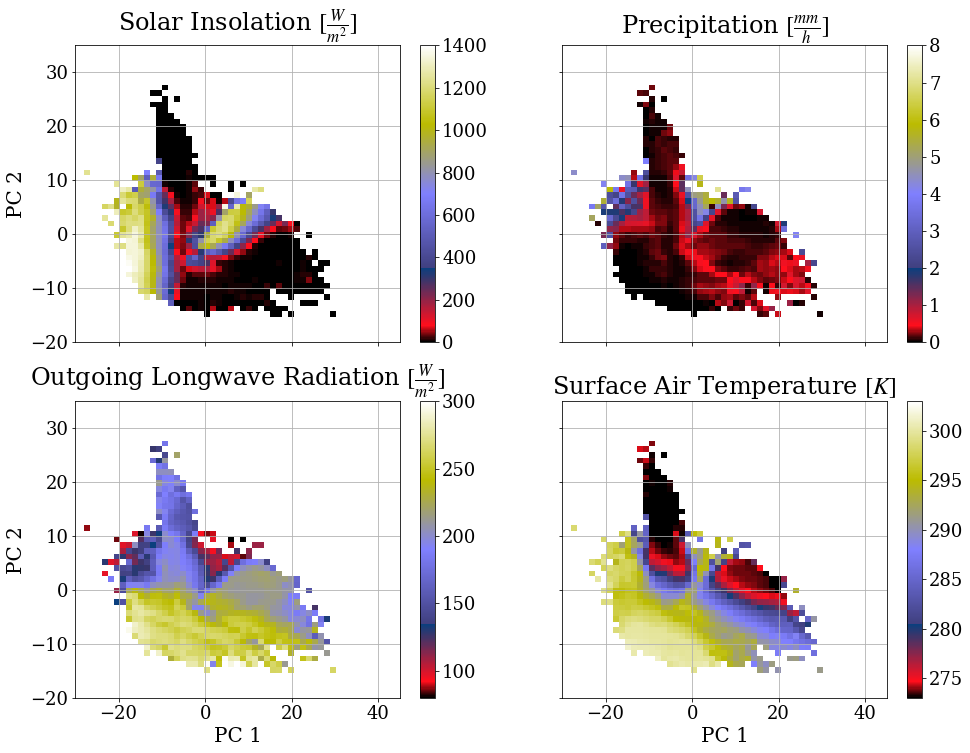

In [35]:
fig = plt.figure(4,(16,12))


ax1 = fig.add_subplot(2,2,1)
imag1=ax1.pcolormesh(xx,yy,SOLIN,cmap=plt.cm.gist_stern)
ax1.grid(True)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
ax1.set_xticklabels([])
plt.ylabel('PC 2', Fontsize=20)
imag1.set_clim(SOLIN_min,SOLIN_max)
plt.colorbar(imag1)






ax2 = fig.add_subplot(2,2,2)
imag2=ax2.pcolormesh(xx,yy,precipitation,cmap=plt.cm.gist_stern)
ax2.grid(True)
plt.title('Precipitation '+r'$[\frac{mm}{h}]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

imag2.set_clim(prec_min,prec_max_glob)

plt.colorbar(imag2)

ax3 = fig.add_subplot(2,2,3)
imag3=ax3.pcolormesh(xx,yy,OLR,cmap=plt.cm.gist_stern)
ax3.grid(True)
plt.title('Outgoing Longwave Radiation '+r'$[\frac{W}{m^2}]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
plt.ylabel('PC 2', Fontsize=20)
plt.xlabel('PC 1', Fontsize=20)

imag3.set_clim(OLR_min,OLR_max)
plt.colorbar(imag3)






ax4 = fig.add_subplot(2,2,4)
imag4=ax4.pcolormesh(xx,yy,T_surf,cmap=plt.cm.gist_stern)
ax4.grid(True)
plt.title('Surface Air Temperature '+r'$[K]$',Fontsize=24)
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
ax4.set_yticklabels([])
plt.xlabel('PC 1',Fontsize=20)
imag4.set_clim(T_min,T_max)

plt.colorbar(imag4)





<ipython-input-36-ffe2cd97f818>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_pca[:,0],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
<ipython-input-36-ffe2cd97f818>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
<ipython-input-36-ffe2cd97f818>:16: MatplotlibDeprecationWarning: shadin

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

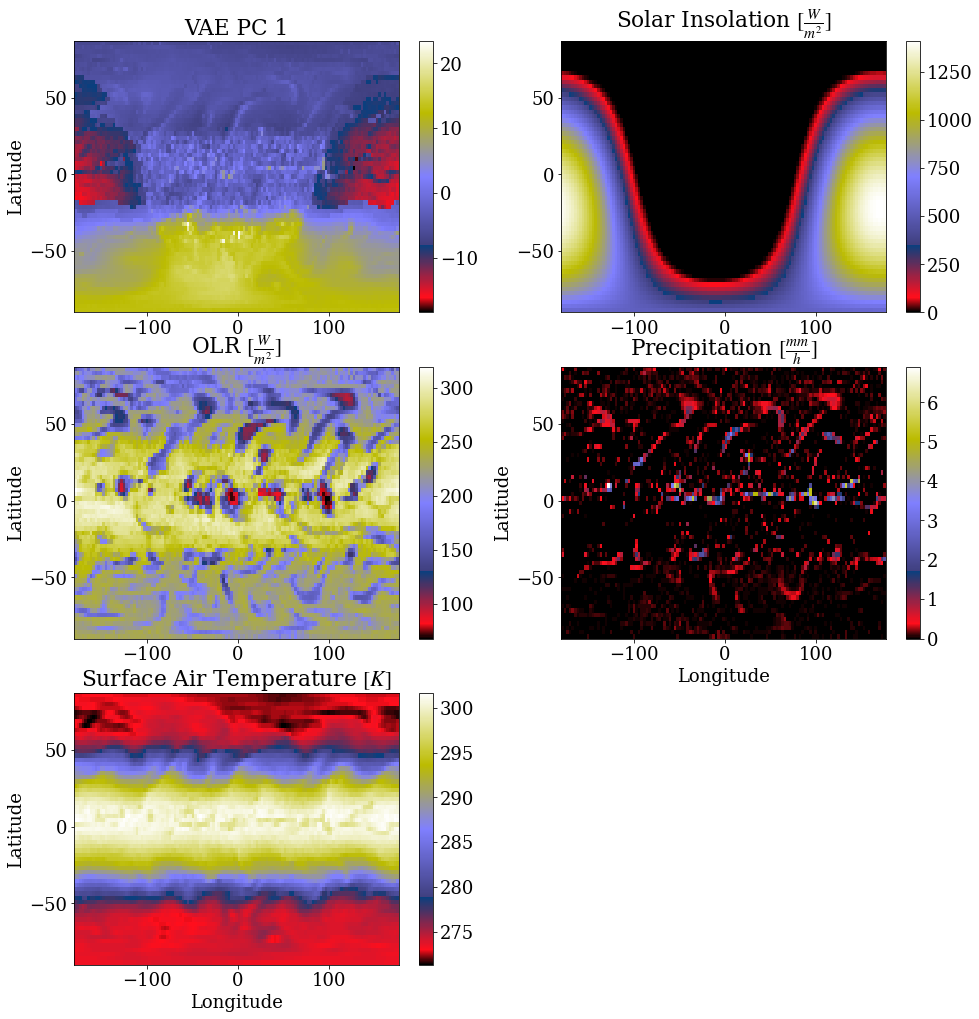

In [36]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_pca[:,0],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('VAE PC 1')

plt.subplot(3,2,2)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,3)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,5)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')




<ipython-input-37-bdd541c2424c>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_pca[:,1],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
<ipython-input-37-bdd541c2424c>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
<ipython-input-37-bdd541c2424c>:16: MatplotlibDeprecationWarning: shadin

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

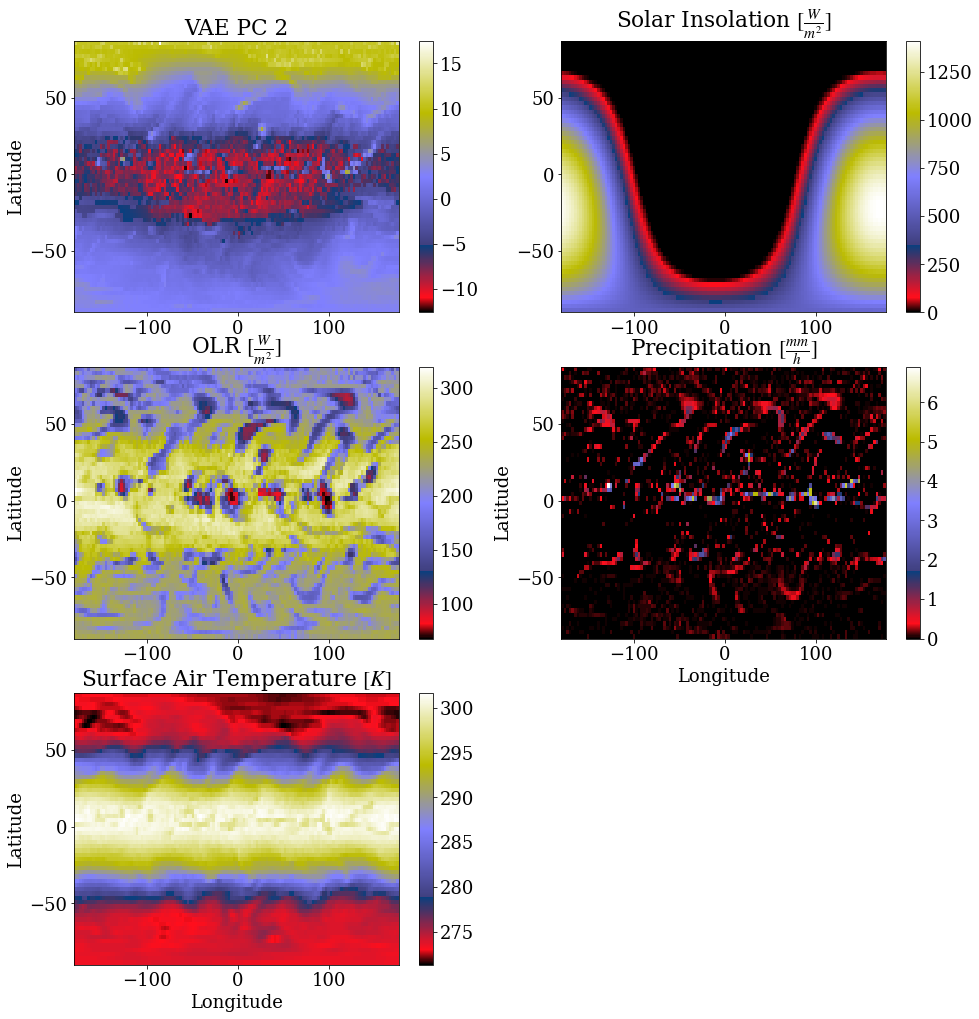

In [37]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_pca[:,1],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('VAE PC 2')

plt.subplot(3,2,2)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,3)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,5)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[25,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')




<ipython-input-39-3e25c3c822fc>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_pca[:,0],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-39-3e25c3c822fc>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-39-3e25c3c822fc>:16: MatplotlibDeprecationWarning: shadin

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

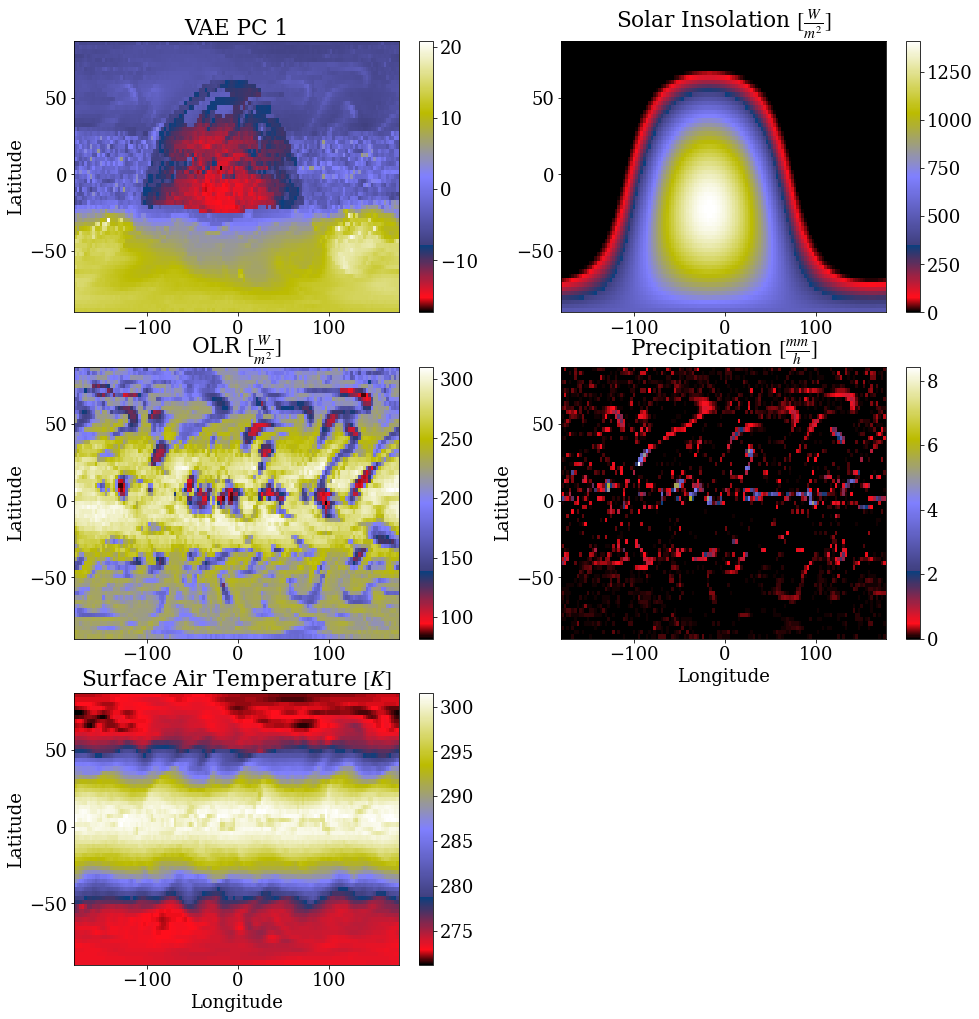

In [39]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_pca[:,0],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('VAE PC 1')

plt.subplot(3,2,2)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,3)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,5)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')




<ipython-input-40-57f378912778>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_pca[:,1],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-40-57f378912778>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-40-57f378912778>:16: MatplotlibDeprecationWarning: shadin

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

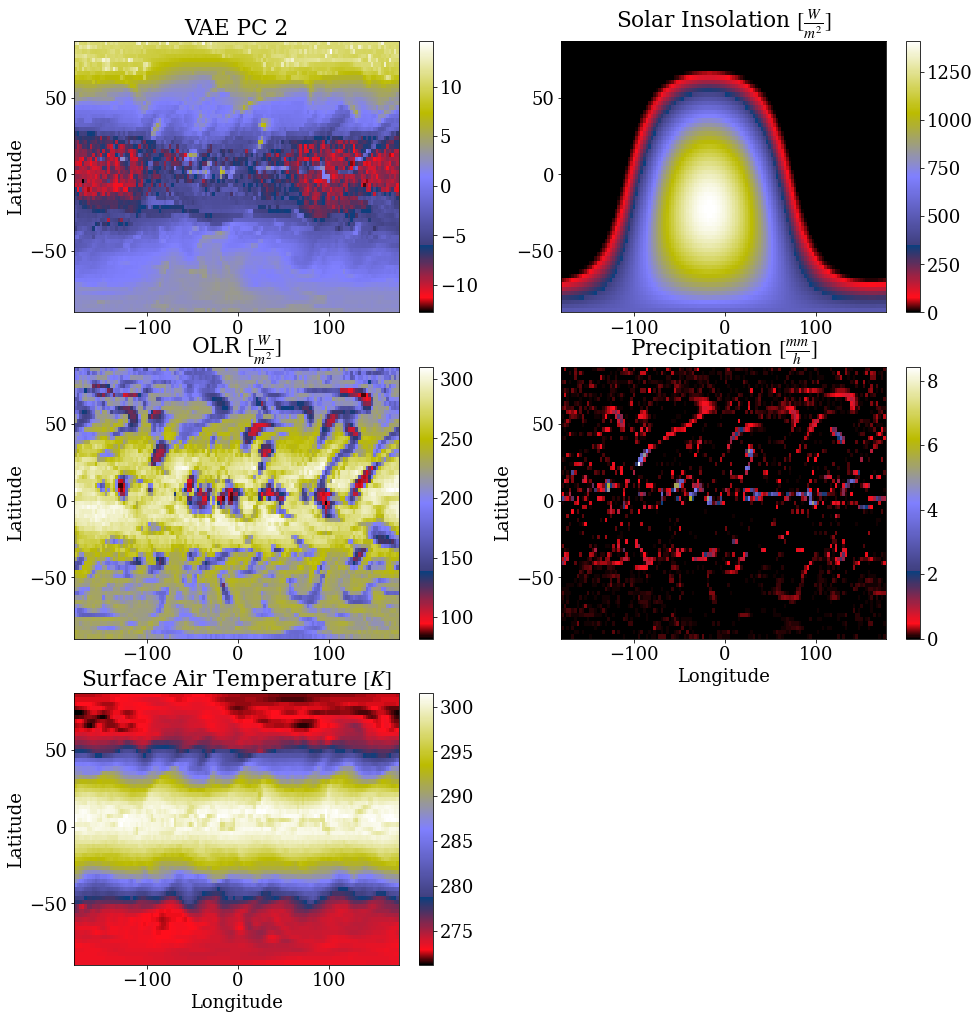

In [40]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_pca[:,1],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('VAE PC 2')

plt.subplot(3,2,2)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,3)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,5)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')




# Plots for the latent variables itself


<ipython-input-23-19ddec540381>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,4],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-23-19ddec540381>:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,1],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-23-19ddec540381>:17: MatplotlibDeprecationWarning: sha

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

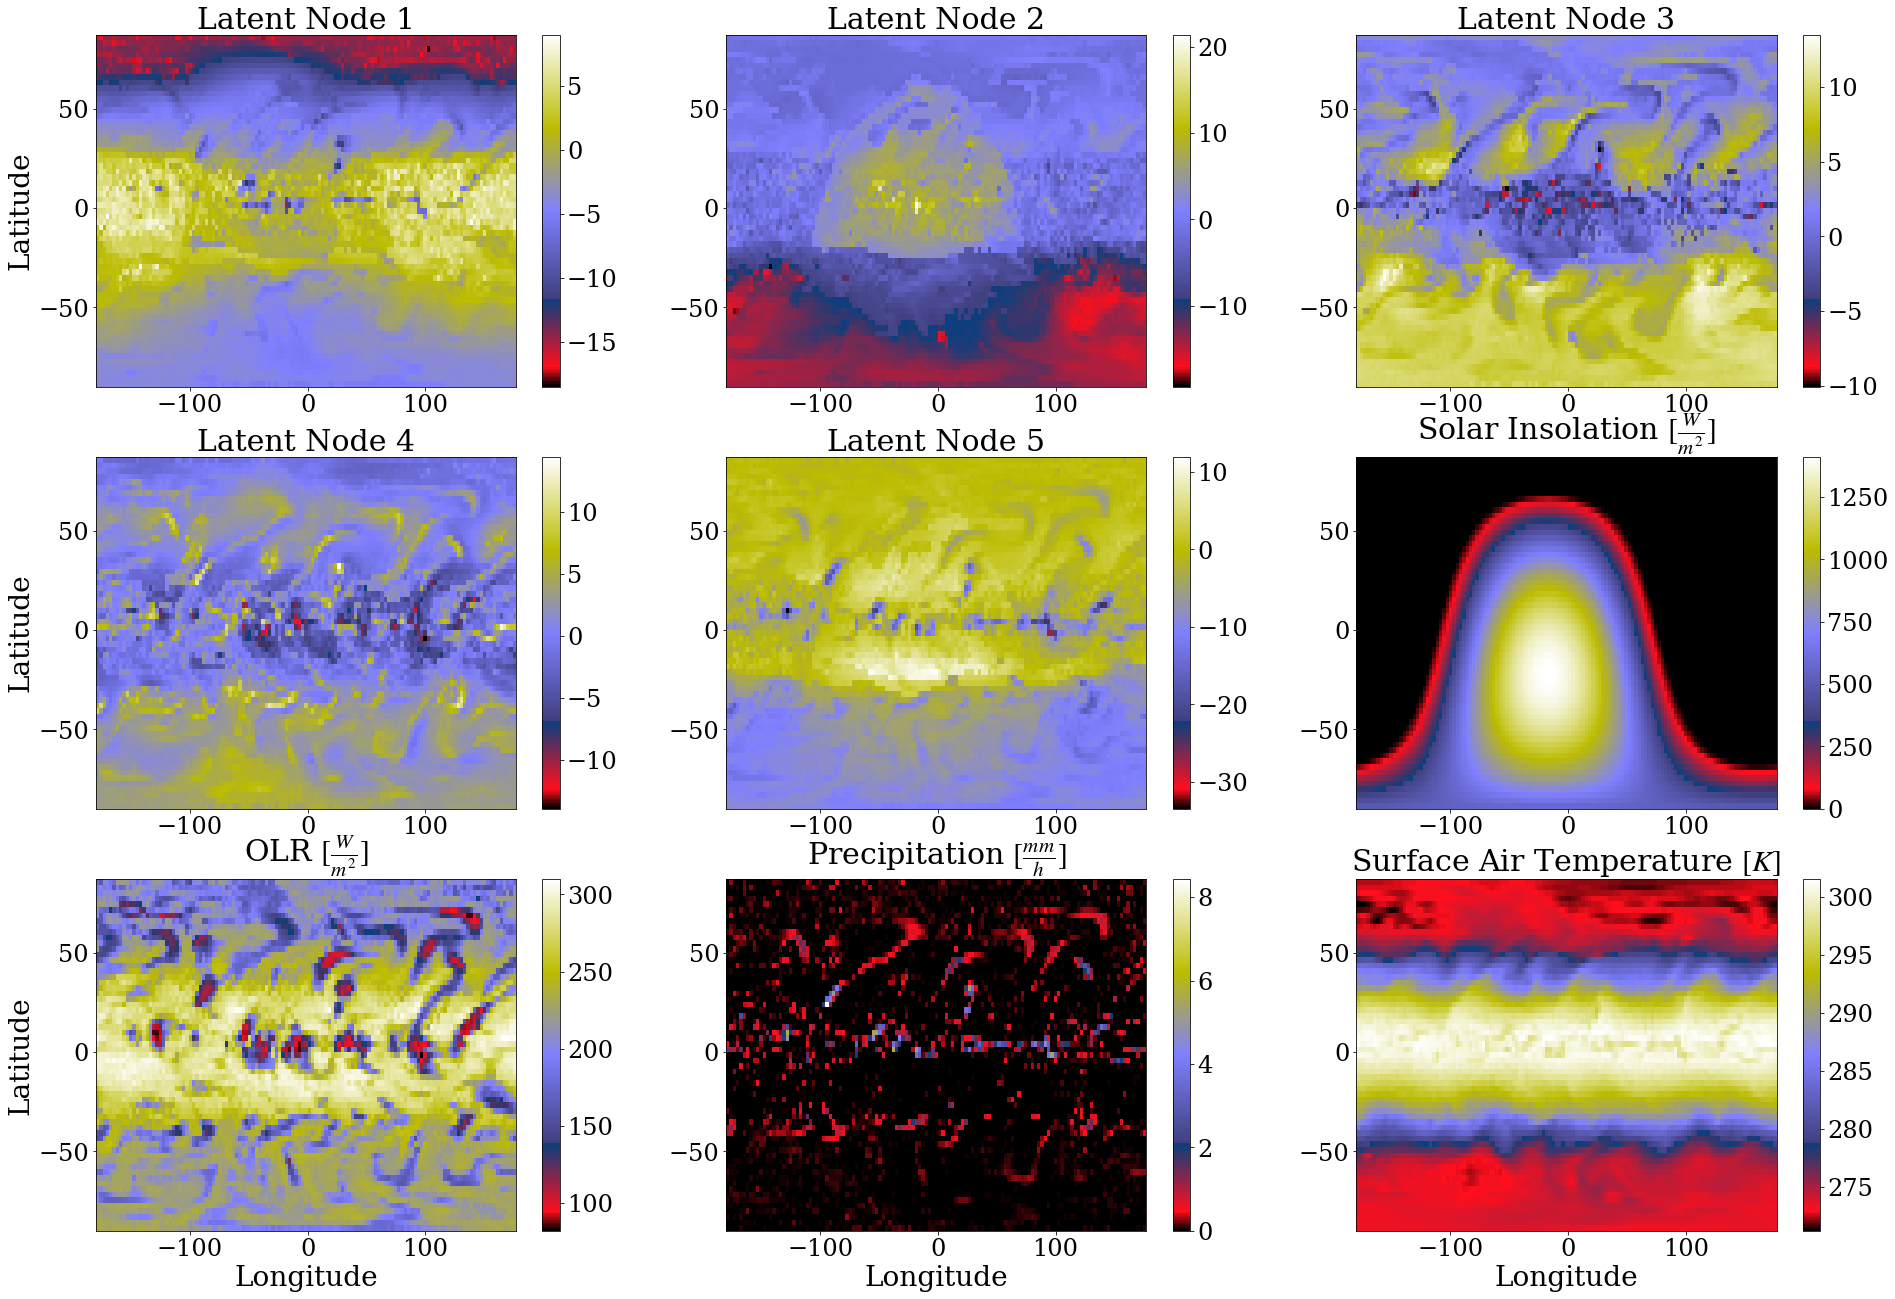

In [23]:
fig = plt.figure(4,(32,22))
plt.subplot(3,3,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,4],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude',fontsize=28)
plt.title('Latent Node 1',fontsize=30)



plt.subplot(3,3,2)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,1],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
#plt.ylabel('Latitude')
plt.title('Latent Node 2',fontsize=30)

plt.subplot(3,3,3)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,0],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
#plt.ylabel('Latitude')
plt.title('Latent Node 3',fontsize=30)

plt.subplot(3,3,4)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,2],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude',fontsize=28)
plt.title('Latent Node 4',fontsize=30)

plt.subplot(3,3,5)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,3],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
#plt.ylabel('Latitude')
#plt.xlabel('Longitude',fontsize=25)

plt.title('Latent Node 5',fontsize=30)



plt.subplot(3,3,6)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$',fontsize=30)
#plt.ylabel('Latitude',fontsize=25)
#plt.xlabel('Longitude',fontsize=25)




plt.subplot(3,3,7)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude',fontsize=28)
plt.xlabel('Longitude',fontsize=28)
plt.title('OLR '+r'$[\frac{W}{m^2}]$',fontsize=30)



plt.subplot(3,3,8)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude',fontsize=28)
#plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$',fontsize=30)


plt.subplot(3,3,9)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude',fontsize=28)
#plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$',fontsize=30)




<ipython-input-42-0632587f2b79>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,1],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-42-0632587f2b79>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-42-0632587f2b79>:16: MatplotlibDeprecationWarning: shading='

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

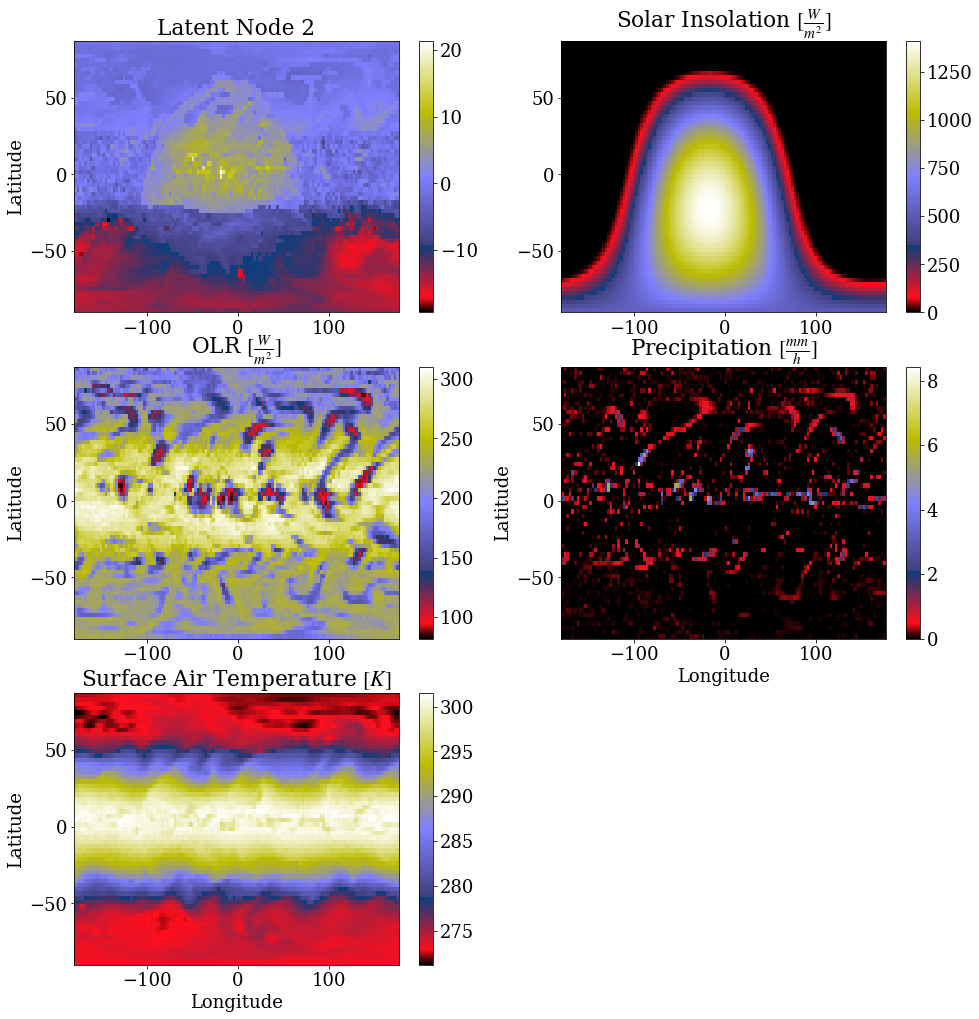

In [42]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,1],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('Latent Node 2')

plt.subplot(3,2,2)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,3)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,5)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')




<ipython-input-43-f0adf936cf3d>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,0],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-43-f0adf936cf3d>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-43-f0adf936cf3d>:16: MatplotlibDeprecationWarning: shading='

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

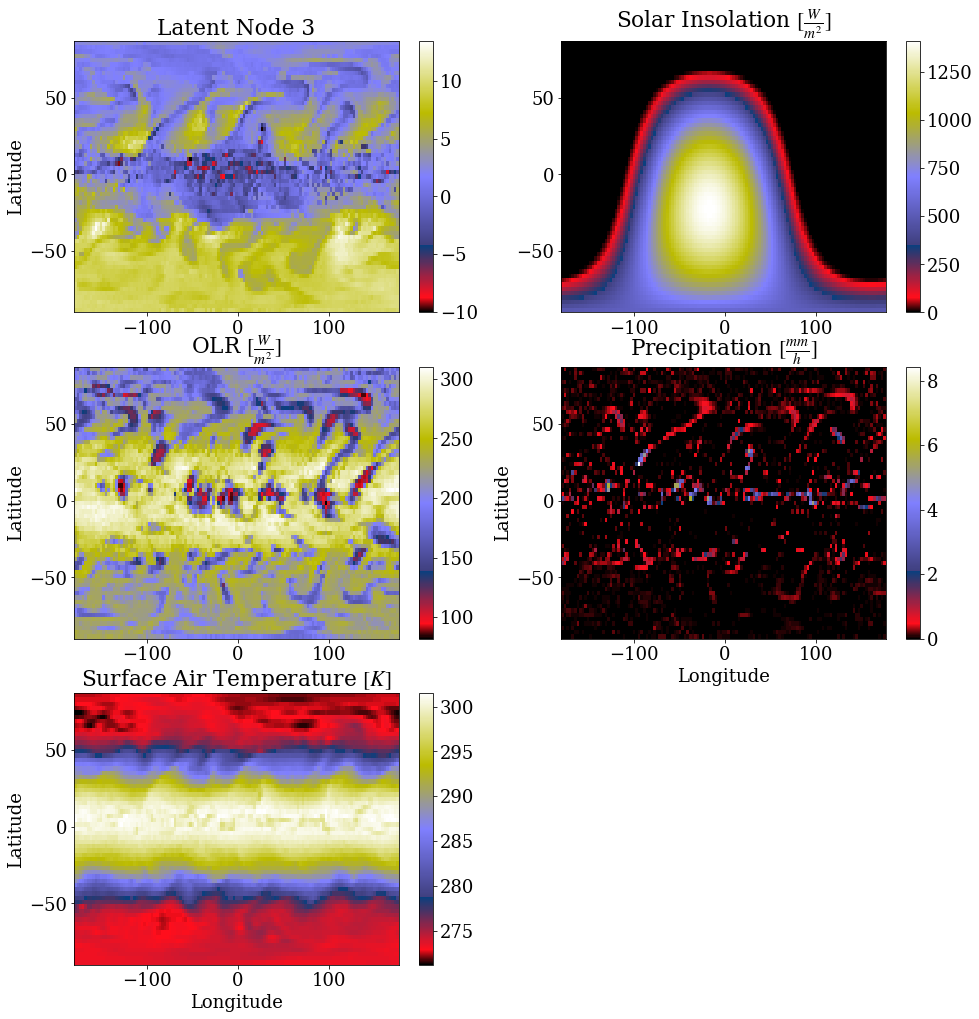

In [43]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,0],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('Latent Node 3')

plt.subplot(3,2,2)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,3)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,5)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')




<ipython-input-44-fc1f05c2b1db>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,2],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-44-fc1f05c2b1db>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-44-fc1f05c2b1db>:16: MatplotlibDeprecationWarning: shading='

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

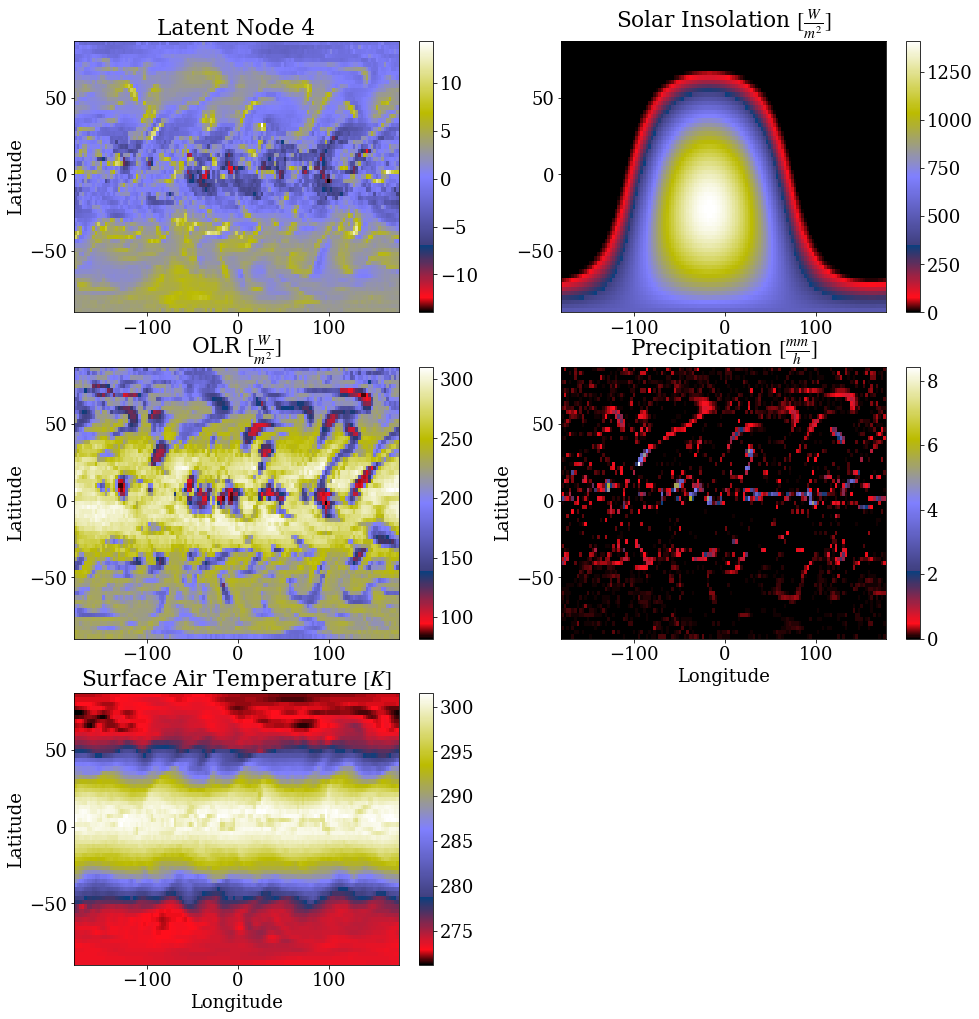

In [44]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,2],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('Latent Node 4')

plt.subplot(3,2,2)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,3)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,5)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')




<ipython-input-45-e1aa078f1e84>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,3],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-45-e1aa078f1e84>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
<ipython-input-45-e1aa078f1e84>:16: MatplotlibDeprecationWarning: shading='

Text(0.5, 1.0, 'Surface Air Temperature $[K]$')

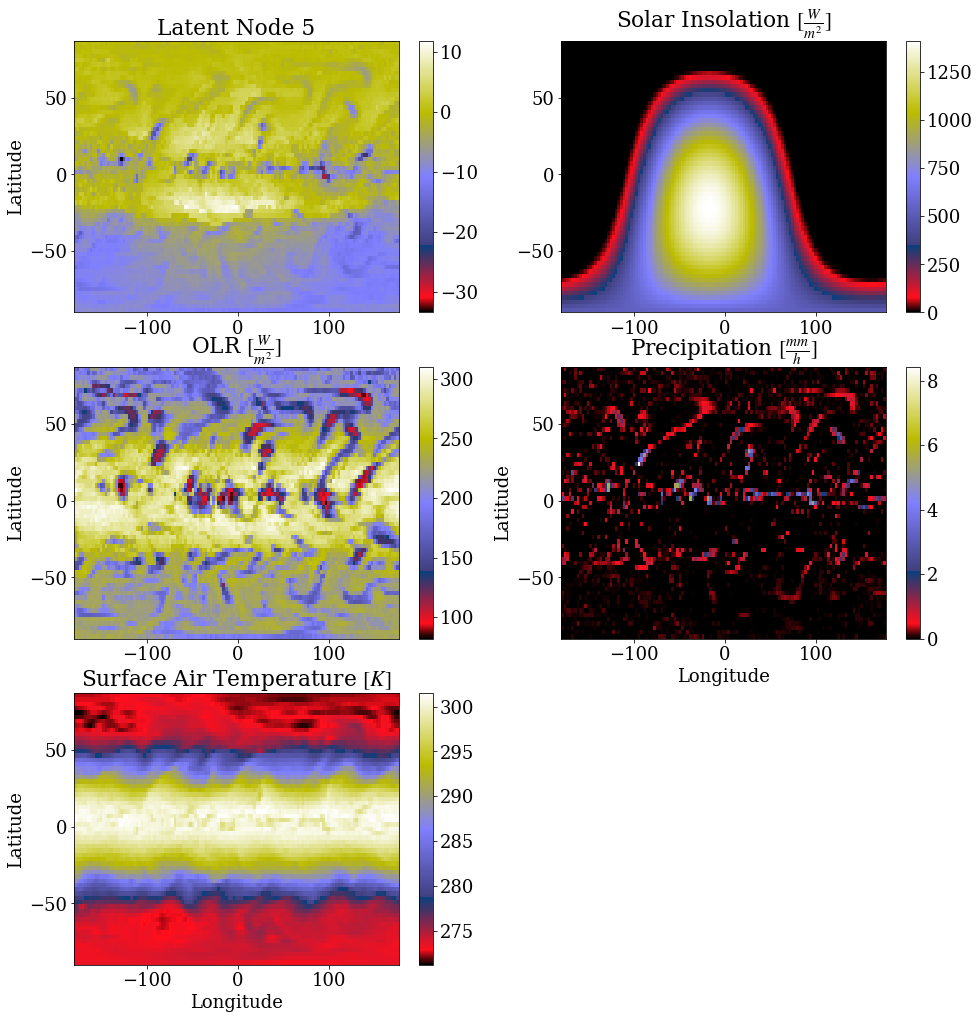

In [45]:
fig = plt.figure(4,(16,17))
plt.subplot(3,2,1)
imag1=plt.pcolormesh(lon,lat,np.reshape(encoder_resp_[:,3],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag1)
plt.ylabel('Latitude')
plt.title('Latent Node 5')

plt.subplot(3,2,2)
imag2=plt.pcolormesh(lon,lat,np.reshape(SOLIN_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag2)
plt.title('Solar Insolation '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,3)
imag3=plt.pcolormesh(lon,lat,np.reshape(OLR_resh[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag3)
plt.ylabel('Latitude')
plt.title('OLR '+r'$[\frac{W}{m^2}]$')



plt.subplot(3,2,4)
imag4=plt.pcolormesh(lon,lat,np.reshape(precip_[:]*3600*1000,(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag4)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Precipitation '+r'$[\frac{mm}{h}]$')


plt.subplot(3,2,5)
imag5=plt.pcolormesh(lon,lat,np.reshape(T_surf_[:],(time,lat.size,lon.size))[50,:],cmap=plt.cm.gist_stern)
plt.colorbar(imag5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Surface Air Temperature '+r'$[K]$')


